In [2]:
#please install keras and tenserflow beforehand
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import os
import random
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/14 15:45:08 WARN Utils: Your hostname, SerennoMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.13.237.96 instead (on interface en0)
22/10/14 15:45:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/14 15:45:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/14 15:45:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# load valid data
tbl_transaction = spark.read.parquet("../data/curated/final_transaction.parquet")
tbl_transaction = tbl_transaction.filter("order_datetime >= '2021-02-28'")
tbl_transaction = tbl_transaction.filter("order_datetime <= '2022-08-28'")

In [4]:
# set the start month to be 1, and convert the date time to how many months has passed from there 
# this is going to be the x axis for multi-layer preceptron
start_month = tbl_transaction.select(min("order_datetime").alias("min_date")).select(month("min_date").cast(IntegerType())).collect()[0][0]
tbl_transaction_temp = tbl_transaction\
    .withColumn('month',month(tbl_transaction.order_datetime).cast(IntegerType()))\
    .withColumn('year',year(tbl_transaction.order_datetime))
    
transaction_month_num =  tbl_transaction_temp.withColumn('month_num',when(tbl_transaction_temp.year == "2022", F.col('month')-start_month+1+12).otherwise(F.col('month')-start_month+1))\
    .drop('month', 'year')



### Predict the merchant's dollar value one month after with multi-layer perceptron

In [5]:
# takes the X values, and group with consecutive n_months(num) elements 
# abcd -> (a,b,c), (b,c,d),...
def consec_data(data_list, n_months):
    X = []
    y = []
    for i in range(len(data_list)):
        end_month = i + n_months
        if end_month > len(data_list)-1:
            break
        get_x, get_y = data_list[i:end_month], data_list[end_month]
        X.append(get_x)
        y.append(get_y)
    return array(X), array(y)


In [9]:
# create model
n_months = 4
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_months))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

In [9]:
# predict the dollar value of one month after
# preparation
MONTH_PERIOD = 18
predict_store = []
counts = 0
save_freq = 100

data = transaction_month_num.select("merchant_abn", "dollar_value", "month_num")
distinct_merchants = sorted(data.select("merchant_abn").distinct().rdd.flatMap(lambda x: x).collect())
n_merchnts = len(distinct_merchants)

# create an empty dataframe with month period as columns
month = [m for m in range(1, MONTH_PERIOD+2)]
zeros = [0]*MONTH_PERIOD
month_list_initial = zip(month,zeros)
initial_df = spark.createDataFrame(data=month_list_initial, schema = ["month_num", "zeros"])



In [5]:
# this code will take 4500 minutes so please think carefully before running

#create a model and predict for each merchant
for merchant in distinct_merchants:
    one_merchant_data = data.filter(F.col("merchant_abn")==merchant)\
                            .groupBy(F.col("month_num"))\
                            .agg(F.avg("dollar_value").alias("avg_dollar_value"))

    #add month row with dollar value = 0 in case data from any month was missing
    one_merchant_and_missing_months = initial_df.join(one_merchant_data, initial_df.month_num == one_merchant_data.month_num, "left")\
                    .drop(one_merchant_data.month_num)\
                    .na.fill(value=0)\
                    .sort(initial_df.month_num)\

    #fit the model
    list_dollar = one_merchant_and_missing_months.select("avg_dollar_value").rdd.flatMap(lambda x: x).collect()
    X, y = consec_data(list_dollar, n_months)
    model.fit(X, y, epochs=100, verbose=0)


    #predict using the model
    x_input = array(list_dollar[-n_months:])
    x_input = x_input.reshape((1, n_months))
    ypredict = model.predict(x_input, verbose=0)
    predict_store.append((merchant, (ypredict[0][0]).item()))

    #save for each 100 merchant prediction
    if len(predict_store)%save_freq == 0:
        save_df = spark.createDataFrame(data=predict_store, schema = ["merchant_abn","predict_dollar_value"])
        save_df.write.mode("overwrite").parquet(f"../data/curated/prediction/predicted_dollar_value{counts}.parquet")
        predict_store = []
        counts += 1
    elif ((counts)*save_freq+len(predict_store)) == n_merchnts: #last remaining data
        save_df = spark.createDataFrame(data=predict_store, schema = ["merchant_abn","predict_dollar_value"])
        save_df.write.mode("overwrite").parquet(f"../data/curated/prediction/predicted_dollar_value{counts}.parquet")
    else:
        continue
    

KeyboardInterrupt: 

referenced cite: 
- https://bobrupakroy.medium.com/multi-layer-perception-time-series-8a1bddbb033a
- https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
- https://codeit.us/blog/machine-learning-time-series-forecasting#:~:text=Time%20series%20forecasting%20in%20machine%20learning,-Before%20anything%20else&text=Time%20Series%20pertains%20to%20the,%22why%22%20behind%20its%20dataset.

### plot the historical and predicted dollar values together

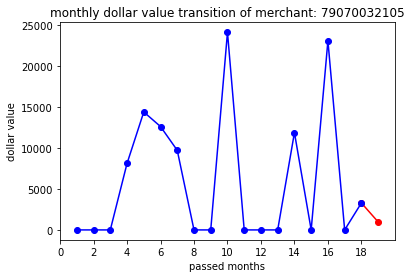

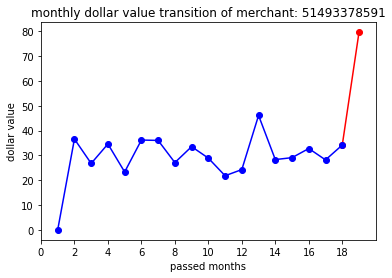

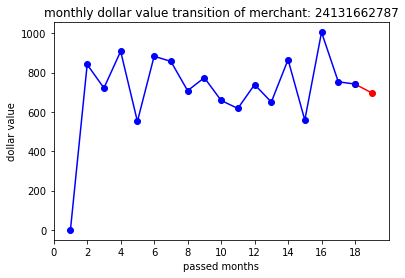

In [10]:
prediction = spark.read.parquet('../data/curated/prediction/predicted_dollar_value0.parquet')
for counts in range(1,45):
    counts =  str(counts)
    prediction_add = spark.read.parquet(f"../data/curated/prediction/predicted_dollar_value{counts}.parquet")
    prediction = prediction.union(prediction_add)

for n in random.sample(range(n_merchnts),3):
    one_merchant_data = data.filter(F.col("merchant_abn")==distinct_merchants[n])\
                            .groupBy(F.col("month_num"))\
                            .agg(F.avg("dollar_value").alias("avg_dollar_value"))

    #add month row with dollar value = 0 in case data from any month was missing
    one_merchant_and_missing_months = initial_df.join(one_merchant_data, initial_df.month_num == one_merchant_data.month_num, "left")\
                    .drop(one_merchant_data.month_num)\
                    .na.fill(value=0)\
                    .sort(initial_df.month_num)
                  
    one_prediction = prediction.filter(F.col("merchant_abn") == distinct_merchants[n]).collect()[0]
    temp = spark.createDataFrame([(MONTH_PERIOD+1, one_prediction[1])], ["month_num", "avg_dollar_value"])
    transition = one_merchant_and_missing_months.drop(F.col("zeros")).unionByName(temp)
    pdf = transition.orderBy("month_num").toPandas()
    pred_pdf = temp.toPandas()
    plt.plot(pdf.iloc[MONTH_PERIOD-1:, 0], pdf.iloc[MONTH_PERIOD-1:, 1],  color = "red", marker = "o")
    plt.plot(pdf.iloc[0:MONTH_PERIOD, 0], pdf.iloc[0:MONTH_PERIOD, 1],  color = "blue", marker = "o")
    plt.ylabel("dollar value")
    plt.xlabel("passed months")
    plt.xlim(0, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.title(f"monthly dollar value transition of merchant: {distinct_merchants[n]}")
    plt.savefig(f"../plots/dollar_value_transition_graph_{distinct_merchants[n]}.jpg", bbox_inches= "tight")
    plt.show()